In [8]:
import copy
import json
import os
import numpy as np
import kernel
import configuration
import calibration
from matplotlib import pyplot as plt

In [2]:
def test_data(c_path, w_path, e_path, json_path, offset=1, printing=True): 
    descriptors = np.loadtxt(c_path)
    weights = np.loadtxt(w_path)
    e_ave = np.loadtxt(e_path)[0]
    with open(json_path, 'r') as u_conf:
            user_config = json.load(u_conf)

    # make a list of the allowed qs
    qs = np.arange(1, user_config['nr_modi']+1) * np.pi / user_config['cutoff']

    # read in data and save parameters for calibration comparison
    (nc_new, ni_new, lat, configurations) = calibration.load_data(user_config, offset)

    config = configurations[0]
    
    if printing:
        for key, value in user_config.items():
            if type(value) != list:
                print(f'{key:>15}: {value:<15}')
            else:
                print(f'{key:>15}: {value[0]:<15}')
                print(f'{"sigma":>15}: {value[1]:<15}')

    nc_old = int(weights.size / 64)
    ni_old = 64

    kern = kernel.Kernel(*user_config['kernel'])

    config.init_nn(user_config['cutoff'], lat)
    config.init_descriptor(qs)

    E, F_reg = kern.predict(qs, config, descriptors, weights, e_ave)
    
    delta_F = F_reg - config.forces
    F_mean = np.mean(np.linalg.norm(delta_F, axis=1))
    F_var = np.var(np.linalg.norm(delta_F, axis=1))

    signs_reg = np.sign(F_reg)
    signs_ana = np.sign(config.forces)
    sign_diff = signs_reg - signs_ana
    
    if printing:
        print('\nPredicted values:')
        print(f'energy = {E}')
        print(f'forces = {F_reg[1]}\n')

        print('Values from Outcar:')
        print(f'energy = {config.energy}')
        print(f'forces = {config.forces[1]}')
        print('\nSign differences:', sign_diff[sign_diff != 0].size, 'out of', sign_diff.size)
        #print(sign_diff)


        print(f'Mean norm of difference:\n {F_mean} +- {F_var}')
        print(f'Relative to size of F:\n {F_mean / np.mean(np.linalg.norm(config.forces, axis=1))}')
    return(F_mean, F_var,  sign_diff[sign_diff != 0].size)



In [130]:
def min_sigma_of_axis(data, axis):
    return data[np.where(data[:, axis] == np.amin(data[:, axis]))][0]
    
def plot3(data: np.array, max_n, title=""):
    fig, axs = plt.subplots(1, 3, figsize = (20, 5))
    fig.suptitle(title, fontsize=16)
    titles = ["mean", "variance", "sign difference"]
    for i in range(1, 4):
        axs[i-1].plot(data[:max_n, 0], data[:max_n, i])
        axs[i-1].grid()
        axs[i-1].set(xlabel="$\sigma$", title=titles[i-1])
        if i != 3:
            axs[i-1].set_yscale('log')

def analyze(n: int, modi: int, max_n=-1):
    fit = np.loadtxt(f'test_data/fit_{n}-{modi}.dat')
    print('Minimize values in fitting')
    print(f'{"sigma":10}|{"mean":10}|{"var":10}|{"signs":10}|')
    for i in range(1, 4):
        line = ""
        for val in min_sigma_of_axis(fit, i):
            line += f'{val:10.5f}|'
        print(line)
    
    print("\n")
    prediction = np.loadtxt(f'test_data/prediction_{n}-{modi}.dat')
    print('Minimize values in prediction')
    print(f'{"sigma":10}|{"mean":10}|{"var":10}|{"signs":10}|')
    for i in range(1, 4):
        line = ""
        for val in min_sigma_of_axis(prediction, i):
            line += f'{val:10.5f}|'
        print(line)
        
    plot3(fit, max_n, "Fitting")
    plot3(prediction, max_n, "Prediction")

# Linear Kernel

In [77]:
test_data('test_data/c_lin_10.out', 'test_data/w_lin_10.out', 'test_data/e_lin_10.out', 'test_data/lin_10.json')

        file_in: OUTCAR.21      
       file_out: test_data      
       stepsize: 1000           
         cutoff: 4              
        nr_modi: 10             
         lambda: 0.001          
         kernel: linear         
          sigma:                

Predicted values:
energy = -307.3937472587071
forces = [ 0.6930024  -0.21777951 -0.47929145]

Values from Outcar:
energy = -306.56723878
forces = [ 0.463753 -0.593154 -0.339427]

Sign differences: 28 out of 192
Mean norm of difference:
 0.49890646576586417 +- 0.04779279743831686
Relative to size of F:
 0.3724728151966518


(0.49890646576586417, 0.04779279743831686, 28)

# Gaussian Kernel

In [4]:
test_data('test_data/c_gaus_10.out', 'test_data/w_gaus_10.out', 'test_data/e_gaus_10.out', 'test_data/gaus_10.json')     

        file_in: OUTCAR.21      
       file_out: test_data      
       stepsize: 1000           
         cutoff: 4              
        nr_modi: 10             
         lambda: 0.001          
         kernel: gaussian       
          sigma: 1              

Predicted values:
energy = -307.9103162022497
forces = [-32.09861649  -5.30471067 -13.71075235]

Values from Outcar:
energy = -306.56723878
forces = [ 0.463753 -0.593154 -0.339427]

Sign differences: 92 out of 192
Mean norm of difference:
 28.491481832043167 +- 1205.438889367551
Relative to size of F:
 21.271126303834496


(28.491481832043167, 1205.438889367551, 92)

# Bigger sigma

In [5]:
test_data('data/calibration_C.out', 'data/calibration_w.out', 'data/calibration_E.out', 'user_config.json', 0)

        file_in: OUTCAR.21      
       file_out: data           
       stepsize: 100            
         cutoff: 4              
        nr_modi: 10             
         lambda: 1e-12          
         kernel: gaussian       
          sigma: 43.5           

Predicted values:
energy = -322.755429689861
forces = [ 0.05307643  0.46457891 -0.6442697 ]

Values from Outcar:
energy = -306.41169589
forces = [ 0.354149 -0.521376 -0.257292]

Sign differences: 56 out of 192
Mean norm of difference:
 1.2767101672902608 +- 0.39015734229006993
Relative to size of F:
 0.9287398543484863


(1.2767101672902608, 0.39015734229006993, 56)

# Analyzing the influence of $\sigma$ in correspondence to nr of modi
---
#### nr_modi = 10

Minimize values in fitting
sigma     |mean      |var       |signs     |
   7.50000|   0.33095|   0.01940|  18.00000|
   7.75000|   0.37101|   0.01861|  19.00000|
   7.50000|   0.33095|   0.01940|  18.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
   7.50000|   0.37449|   0.02381|  18.00000|
   6.25000|   0.38715|   0.01906|  18.00000|
   5.25000|   0.41314|   0.02500|  16.00000|


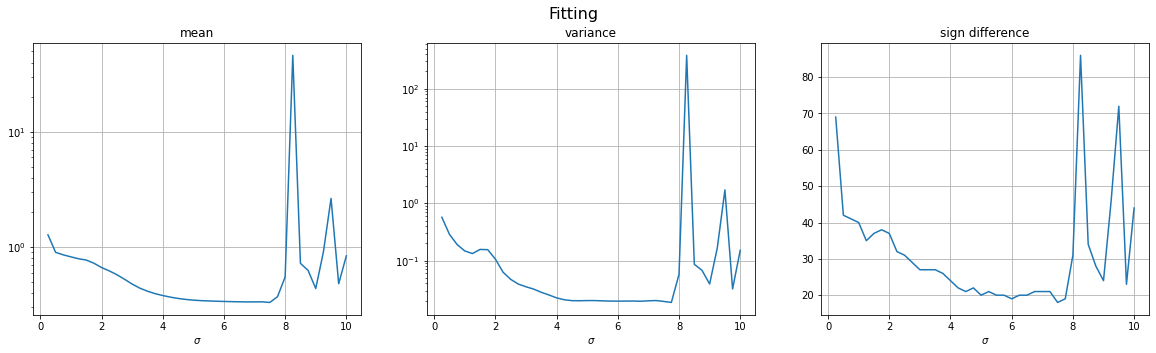

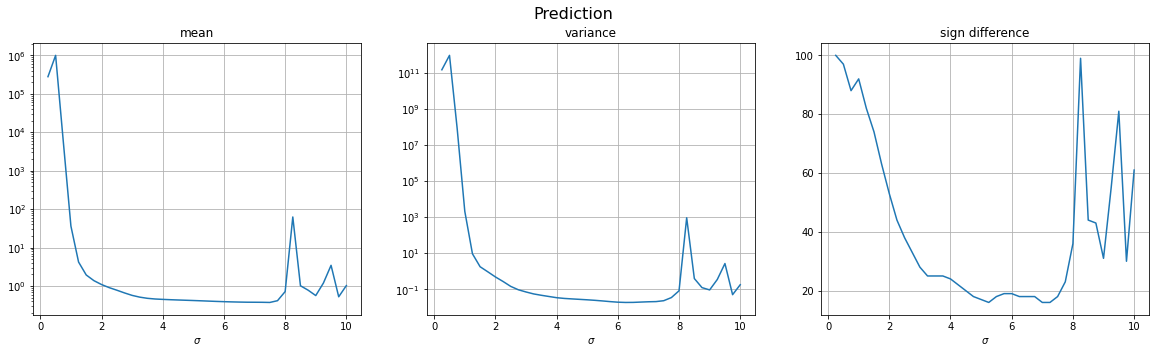

In [132]:
analyze(200, 10, 40)

#### nr_modi = 8

Minimize values in fitting
sigma     |mean      |var       |signs     |
   3.75000|   0.33839|   0.02119|  20.00000|
   3.00000|   0.36429|   0.01790|  20.00000|
   4.75000|   0.34142|   0.01939|  18.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
   4.00000|   0.39891|   0.02430|  22.00000|
   4.75000|   0.39987|   0.02322|  22.00000|
   3.25000|   0.42143|   0.03052|  19.00000|


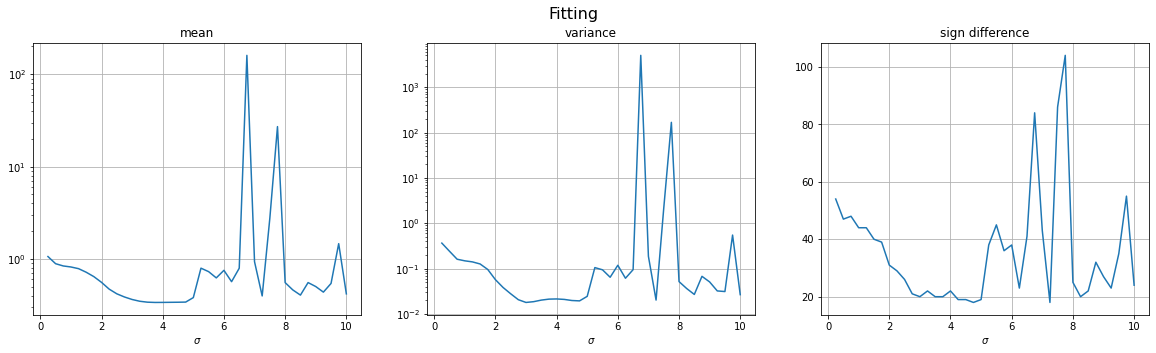

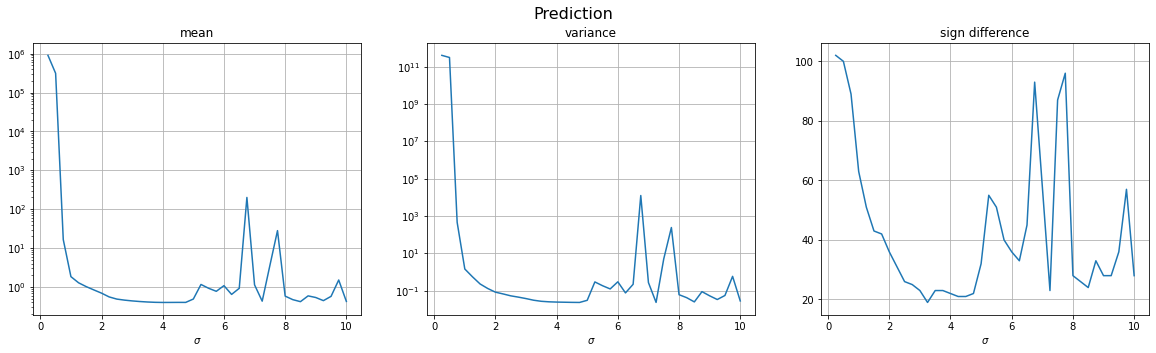

In [131]:
analyze(200, 8, 40)

In [126]:
a = np.array([[0, 1, 1, 1],[1, 0, 2, 3], [2, -5, 4, 5]])
print(a)
min_sigma_of_axis(a, 1)

[[ 0  1  1  1]
 [ 1  0  2  3]
 [ 2 -5  4  5]]


array([ 2, -5,  4,  5])